In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    precision_score, recall_score, f1_score,
    accuracy_score,
    precision_recall_curve, auc
)
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [35]:
output_path = "./dataset/out.csv"
train_path = "./dataset/train_c.csv"
test_path = "./dataset/test_c.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

## EDA

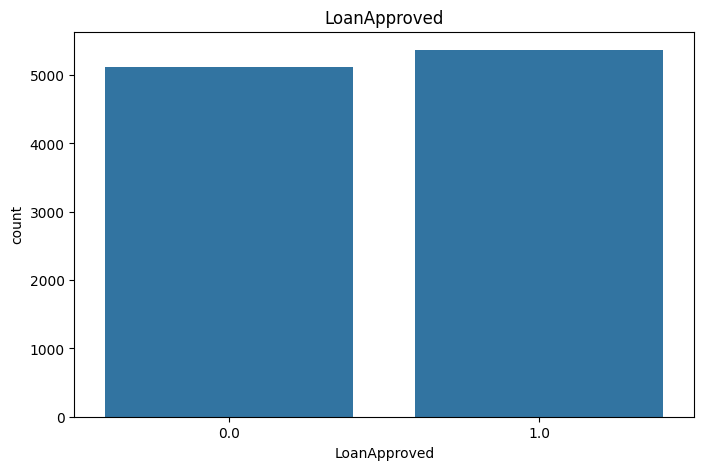

Количество числовых признаков: 29
Признаки: ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved']
Топ положительных корреляций с LoanApproved:
MonthlyIncome              0.754853
AnnualIncome               0.743034
CreditScore                0.581812
NetWorth                   0.129624
TotalAssets                0.129204
LengthOfCreditHistory      0.038509
Experience                 0.036699
Age                        0.036580
DebtToIncomeRatio          0.014922
NumberOfC

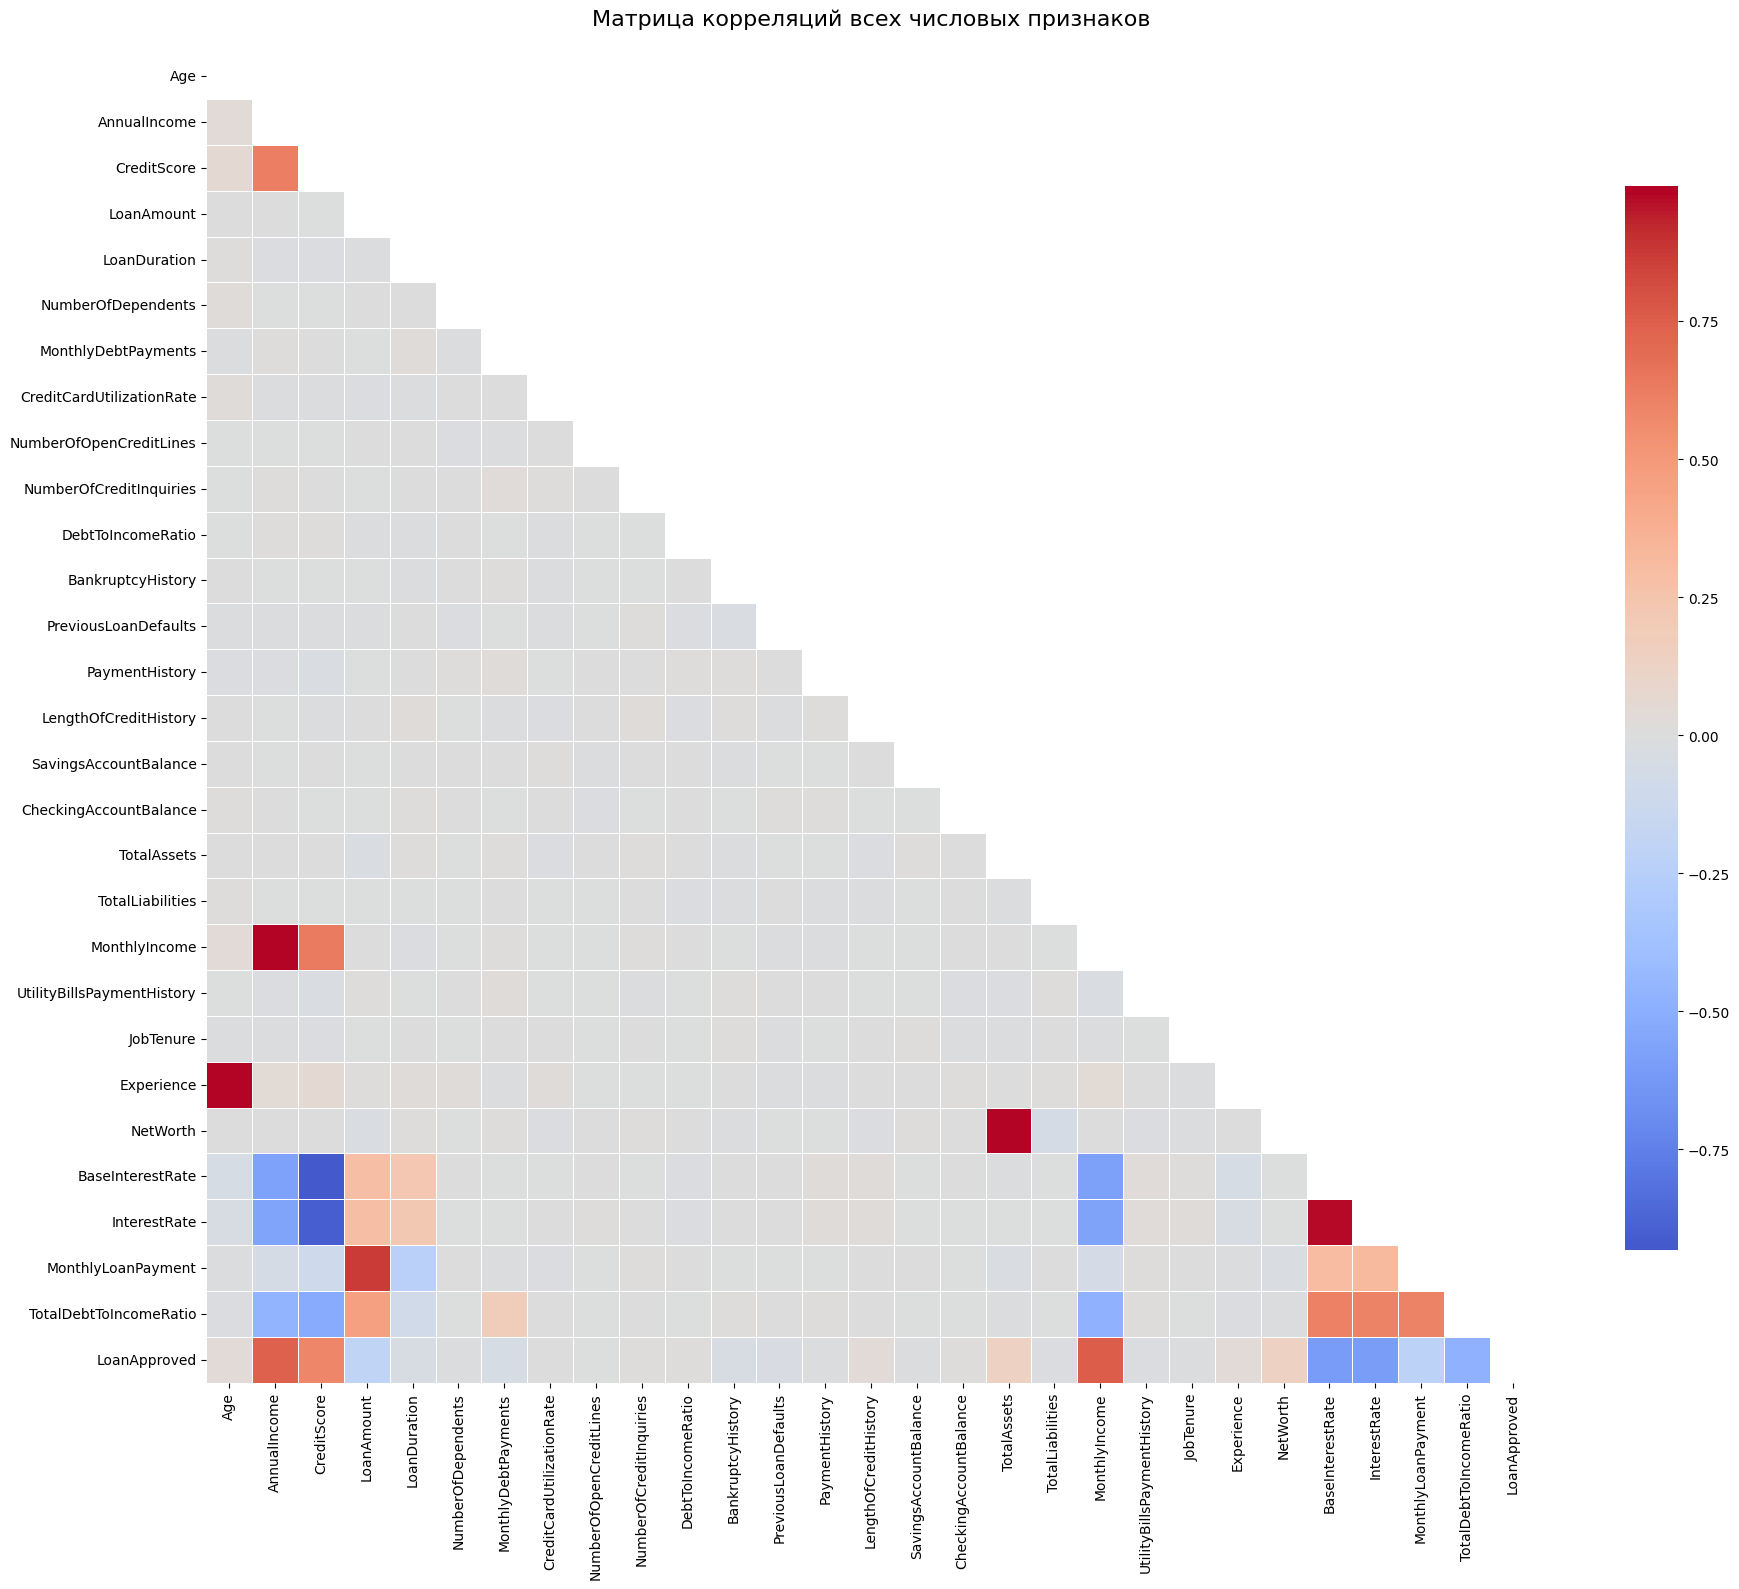

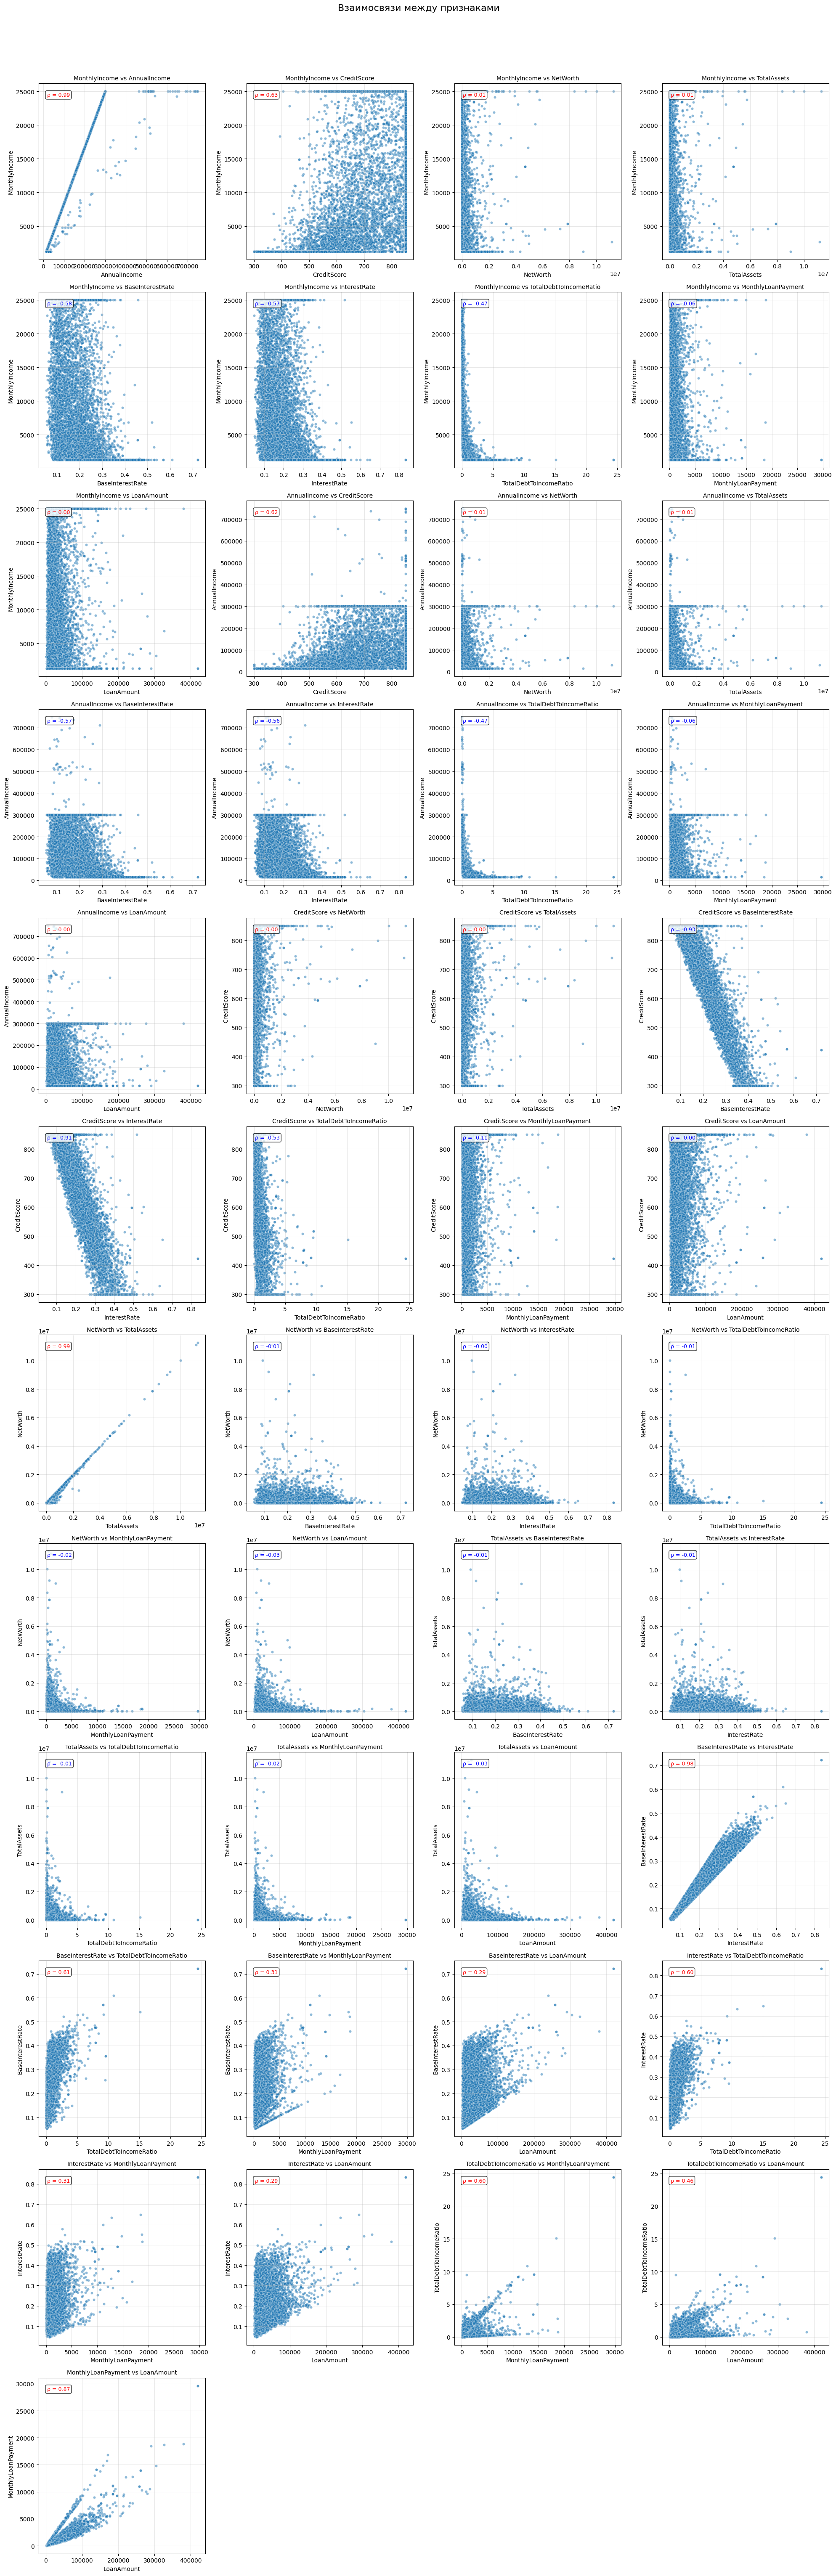

In [36]:
plt.figure(figsize=(8, 5))
sns.countplot(x='LoanApproved', data=train_df)
plt.title('LoanApproved')
plt.show()

numeric_cols = train_df.select_dtypes(include=[np.number]).columns

print(f"Количество числовых признаков: {len(numeric_cols)}")
print(f"Признаки: {list(numeric_cols)}")
corr_matrix = train_df[numeric_cols].corr()
print("Топ положительных корреляций с LoanApproved:")
print(corr_matrix['LoanApproved'].sort_values(ascending=False).head(11)[1:])
print("Топ отрицательных корреляций с LoanApproved:")
print(corr_matrix['LoanApproved'].sort_values(ascending=True).head(10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, 
            cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций всех числовых признаков', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

features_list = [
    'MonthlyIncome', 'AnnualIncome', 'CreditScore',
    'NetWorth', 'TotalAssets', 'BaseInterestRate',
    'InterestRate', 'TotalDebtToIncomeRatio', 'MonthlyLoanPayment',           
    'LoanAmount',
    ]

features_data = train_df[features_list]
n_features = len(features_list)
total_plots = ((n_features - 1) * n_features) // 2
plots_per_row = 4
rows = (total_plots + plots_per_row - 1) // plots_per_row

fig, axes = plt.subplots(rows, plots_per_row, figsize=(20, 5*rows))
axes = axes.ravel()

plot_idx = 0

for i in range(n_features):
    for j in range(i + 1, n_features):
        ax = axes[plot_idx]        
        sns.scatterplot(x=features_list[j], y=features_list[i], 
                        data=features_data, alpha=0.5, s=20, ax=ax)
        
        corr = features_data[features_list[i]].corr(features_data[features_list[j]])
        color = 'red' if corr > 0 else 'blue'
        ax.text(0.05, 0.95, f'ρ = {corr:.2f}', transform=ax.transAxes,
                fontsize=9, color=color, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        ax.set_title(f'{features_list[i]} vs {features_list[j]}', fontsize=10)        
        ax.grid(True, alpha=0.3)  
        plot_idx += 1

for i in range(plot_idx, len(axes)):
    axes[i].axis('off')

plt.suptitle('Взаимосвязи между признаками', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Основная функция преобразования и создания новых признаков

In [37]:
def change_features(df: pd.DataFrame):
    df.drop(columns=['ApplicationDate'], inplace=True)
    mapping = {'High School': 1, 'Associate': 2, 'Bachelor': 3, 'Master': 4, 'Doctorate': 5}
    df['EducationLevel'] = df['EducationLevel'].map(mapping).fillna(0).astype(float)
    df['Income'] = 1 / (np.log1p((df['MonthlyIncome'] + df['AnnualIncome'] / 12) / 2) + 1)
    df['InterestRate2'] = (df['BaseInterestRate'] + df['InterestRate']) / 2
    df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
    df["AgeExperience"] = df["Age"] - df["Experience"] 
    df["NetIncome"] = df["NetWorth"] / (df["AnnualIncome"] + 1)
    df['NetWorth']= np.log1p(df['NetWorth']) ** 3
    df["LoanIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + 1)
    df["HistToAge"] = df["LengthOfCreditHistory"] / (df["Age"] + 1)
    total = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"]
    df["DebtToIncomeRatio2"] = total / (df["MonthlyIncome"] + 1)
    df["RemainingIncome"] = df["MonthlyIncome"] - total
    df["AssetsLiabilities"] = df["TotalAssets"] / (df["TotalLiabilities"] + 1)
    df["LiabilityAssets"] = df["TotalLiabilities"] - df["TotalAssets"]
    df["NetLiabilities"] = df["NetWorth"] / (df["TotalLiabilities"] + 1)
    df["IncomeDependents"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 1)
    df["ExpAge"] = df["Experience"] / (df["Age"] + 1)
    df['AnnualIncome'] = -np.log1p(df['AnnualIncome'])
    df['BaseInterestRate'] = np.log1p(df['BaseInterestRate'])
    df['LoanAmount'] = -np.log1p(df['LoanAmount'])
    scores = [300, 500, 600, 650, 700, 750, 800, 850, 900]
    names = []
    for i in range(len(scores) - 1):
        l, r = scores[i], scores[i + 1]
        names.append(f'{l}-{r}')
    df[f'BinsCreditScore'] = (pd.cut(df['CreditScore'], bins=scores, labels=names, include_lowest=True).astype(str))


In [38]:
class MyBaggingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_estimator=DecisionTreeClassifier(), n_estimators=10, random_state=42):
        self.base_estimator = base_estimator
        self.n_estimators = n_estimators
        self.random_state = random_state
        self.models = []

    def fit(self, X, y):
        self.models = []
        rng = np.random.default_rng(self.random_state)
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            idxs = rng.choice(n_samples, size=n_samples, replace=True)
            X_sample, y_sample = X[idxs], y.iloc[idxs]
            model = clone(self.base_estimator)
            model.fit(X_sample, y_sample)
            self.models.append(model)
        return self

    def predict_proba(self, X):
        return np.mean([model.predict_proba(X) for model in self.models], axis=0)

    def predict(self, X):
        return np.argmax(self.predict_proba(X), axis=1)

In [55]:
class MyGradientBoosting(BaseEstimator, ClassifierMixin):
    def __init__(self, n_estimators=10, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []
        self.initial_pred = None

    def _sigmoid_f(self, z):
        return 1 / (1 + np.exp(-z))

    def fit(self, X, y):
        self.models = []
        pos_frac = np.mean(y)
        self.initial_pred = np.log(pos_frac / (1 - pos_frac))
        y_pred = np.full(y.shape, self.initial_pred)

        for _ in range(self.n_estimators):
            probs = self._sigmoid_f(y_pred)
            model = DecisionTreeRegressor(max_depth=self.max_depth, random_state=42)
            model.fit(X, y - probs)
            y_pred += self.learning_rate * model.predict(X)
            self.models.append(model)

        return self

    def predict_proba(self, X):
        y_pred = np.full(X.shape[0], self.initial_pred)
        for model in self.models:
            y_pred += self.learning_rate * model.predict(X)

        prob1 = self._sigmoid_f(y_pred)
        return np.c_[(1 - prob1, prob1)]

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X)[:, 1] >= threshold).astype(int)

## Подготовка данных

In [39]:
train_df = train_df.dropna(subset=['LoanApproved'])

change_features(train_df)
change_features(test_df)

X = train_df.drop(columns=['LoanApproved'])
y = train_df['LoanApproved'].astype(int)
X_test = test_df.drop(columns=['ID'])

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = list(set(X.columns) - set(numeric_cols))

numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = list(set(X.columns) - set(numeric_cols))

numeric_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="most_frequent")
X_numeric = numeric_imputer.fit_transform(X[numeric_cols])
X_categorical = categorical_imputer.fit_transform(X[categorical_cols])
X_test_numeric = numeric_imputer.transform(X_test[numeric_cols])
X_test_categorical = categorical_imputer.transform(X_test[categorical_cols])

X_numeric = np.log1p(np.abs(X_numeric)) * np.sign(X_numeric)
X_test_numeric = np.log1p(np.abs(X_test_numeric)) * np.sign(X_test_numeric)

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_ohe = ohe.fit_transform(X_categorical)
X_test_ohe = ohe.transform(X_test_categorical)

X_preprocessed = np.hstack([X_numeric, X_ohe])
X_test_preprocessed = np.hstack([X_test_numeric, X_test_ohe])

scaler = StandardScaler()
X_preprocessed = scaler.fit_transform(X_preprocessed)
X_test_preprocessed = scaler.transform(X_test_preprocessed)

print(f"Финальная размерность: {X_preprocessed.shape}")

X_train, X_val, y_train, y_val = train_test_split(
        X_preprocessed, y, test_size=0.2, random_state=42, stratify=y
    )


Финальная размерность: (10487, 67)


## Тест и сравнение bagging

In [53]:
bag_my = MyBaggingClassifier(n_estimators=10, random_state=42)
bag_my.fit(X_train, y_train)
prob_my = bag_my.predict_proba(X_val)[:, 1]

bag_sklearn = RandomForestClassifier(n_estimators=10, random_state=42)
bag_sklearn.fit(X_train, y_train)
prob_sklearn = bag_sklearn.predict_proba(X_val)[:, 1]


print(f'ROC AUC: sk - {roc_auc_score(y_val, prob_sklearn):.4f}; my - {roc_auc_score(y_val, prob_my):.4f}')

ROC AUC: sk - 0.9734; my - 0.9732


## Тест и сравнение бустинга

In [59]:
gb_my = MyGradientBoosting(n_estimators=50)
gb_my.fit(X_train, y_train)
prob_my = gb_my.predict_proba(X_val)[:, 1]

gd_sklearn = GradientBoostingClassifier(n_estimators=50)
gd_sklearn.fit(X_train, y_train)
prob_sklearn = gd_sklearn.predict_proba(X_val)[:, 1]


print(f'ROC AUC: sk - {roc_auc_score(y_val, prob_sklearn):.4f}; my - {roc_auc_score(y_val, prob_my):.4f}')

ROC AUC: sk - 0.9804; my - 0.9748


## Сравнение разных бустингов

In [69]:
import xgboost as xgb
import lightgbm as lgb
import catboost as cb

gb_models = {
    'Sklearn': GradientBoostingClassifier(random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42),
    'CatBoost': cb.CatBoostClassifier(random_state=42, verbose=0)
}

scores = {}
for name, model in gb_models.items():
    model.fit(X_train, y_train)
    prob_pred = model.predict_proba(X_val)[:,1]
    score = roc_auc_score(y_val, prob_pred)
    scores[name] = score
    print(f'ROC-AUC {name}: {score:.4f}')

best_model_name = max(scores, key=scores.get)
print(f"\nПобедила модель: {best_model_name}")

ROC-AUC Sklearn: 0.9821
ROC-AUC LightGBM: 0.9832
ROC-AUC XGBoost: 0.9832
ROC-AUC CatBoost: 0.9845

Победила модель: CatBoost


## Подбор гиперпараметров через optuna

In [70]:
import optuna

def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.35),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'max_depth': trial.suggest_int('max_depth', 2, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 100),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 100),
    }

    model = lgb.LGBMClassifier(**params, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, show_progress_bar=False)

print("Лучшие параметры:", study.best_params)
best_params = study.best_params

[I 2025-12-14 16:51:42,887] A new study created in memory with name: no-name-f3acfb43-f3f1-499f-9a5e-6e7dcd5491ab
[I 2025-12-14 16:51:43,023] Trial 0 finished with value: 0.982756488594041 and parameters: {'n_estimators': 120, 'learning_rate': 0.2215012824046312, 'num_leaves': 73, 'max_depth': 4, 'lambda_l1': 7.137448431850113, 'lambda_l2': 22.298984273678492}. Best is trial 0 with value: 0.982756488594041.
[I 2025-12-14 16:51:43,136] Trial 1 finished with value: 0.9786629277234637 and parameters: {'n_estimators': 271, 'learning_rate': 0.2770656812813341, 'num_leaves': 54, 'max_depth': 6, 'lambda_l1': 54.718082184777316, 'lambda_l2': 0.4294677058896301}. Best is trial 0 with value: 0.982756488594041.
[I 2025-12-14 16:51:43,235] Trial 2 finished with value: 0.9811084257157822 and parameters: {'n_estimators': 108, 'learning_rate': 0.17074698227523316, 'num_leaves': 90, 'max_depth': 3, 'lambda_l1': 24.563906346957086, 'lambda_l2': 9.502150391206875}. Best is trial 0 with value: 0.98275648

Лучшие параметры: {'n_estimators': 171, 'learning_rate': 0.26774867734010455, 'num_leaves': 70, 'max_depth': 8, 'lambda_l1': 1.663401964844568, 'lambda_l2': 31.461131146612722}


In [72]:
best_model = lgb.LGBMClassifier(**best_params, random_state=42, verbose=-1)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_val)

## Реализация собственных метрик

In [73]:
def my_accuracy(y_true, y_pred):
    return np.mean(y_true == y_pred)

def my_precision(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    if tp + fp == 0:
        return 0.0
    return tp / (tp + fp + 1e-12)

def my_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    if tp + fn == 0:
        return 0.0
    return tp / (tp + fn + 1e-12)

def my_f1(y_true, y_pred):
    precision = my_precision(y_true, y_pred)
    recall = my_recall(y_true, y_pred)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall + 1e-12)

def my_roc_auc(y_true, y_pred_proba):
    if len(np.unique(y_true)) != 2:
        raise ValueError("ROC-AUC поддерживает только бинарную классификацию")
    
    thresholds = np.sort(np.unique(y_pred_proba))[::-1]
    thresholds = np.append(thresholds, thresholds[-1] - 1)
    thresholds = np.insert(thresholds, 0, thresholds[0] + 1)
    
    tpr = np.zeros(len(thresholds))
    fpr = np.zeros(len(thresholds))
    
    for i, threshold in enumerate(thresholds):
        y_pred = (y_pred_proba >= threshold).astype(int)
        tp = np.sum((y_true == 1) & (y_pred == 1))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tn = np.sum((y_true == 0) & (y_pred == 0))
        
        if tp + fn > 0:
            tpr[i] = tp / (tp + fn)
        else:
            tpr[i] = 0
            
        if fp + tn > 0:
            fpr[i] = fp / (fp + tn)
        else:
            fpr[i] = 0
    
    auc = 0
    for i in range(1, len(fpr)):
        auc += (fpr[i] - fpr[i-1]) * (tpr[i] + tpr[i-1]) / 2
    
    return auc

def my_average_precision(y_true, y_pred_proba):
    thresholds = np.sort(np.unique(y_pred_proba))[::-1]
    thresholds = np.append(thresholds, 0)
    
    precision_values = []
    recall_values = []
    
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        precision = my_precision(y_true, y_pred)
        recall = my_recall(y_true, y_pred)
        precision_values.append(precision)
        recall_values.append(recall)
    
    precision_values = np.array(precision_values)
    recall_values = np.array(recall_values)
    
    sorted_indices = np.argsort(recall_values)
    precision_values = precision_values[sorted_indices]
    recall_values = recall_values[sorted_indices]
    
    ap = 0
    for i in range(1, len(recall_values)):
        ap += (recall_values[i] - recall_values[i-1]) * precision_values[i]
    
    return ap

Проверяем метрики:

In [75]:
print(f'Accuracy:  my - {my_accuracy(y_val, y_pred):.4f}; sk - {accuracy_score(y_val, y_pred):.4f}')
print(f'Precision: my - {my_precision(y_val, y_pred):.4f}; sk - {precision_score(y_val, y_pred):.4f}')
print(f'Recall:    my - {my_recall(y_val, y_pred):.4f}; sk - {recall_score(y_val, y_pred):.4f}')
print(f'F1-score:  my - {my_f1(y_val, y_pred):.4f}; sk - {f1_score(y_val, y_pred):.4f}')

Accuracy:  my - 0.9304; sk - 0.9304
Precision: my - 0.9312; sk - 0.9312
Recall:    my - 0.9330; sk - 0.9330
F1-score:  my - 0.9321; sk - 0.9321


In [80]:
best_model.fit(X_preprocessed, y)

pred = (best_model.predict_proba(X_test_preprocessed)[:, 1])
sub = pd.DataFrame({
    "ID": test_df.get("ID", np.arange(len(pred))),
    "LoanApproved": pred
})
sub.to_csv(output_path, index=False)